In [1]:
%pylab inline
import nidaqmx

Populating the interactive namespace from numpy and matplotlib


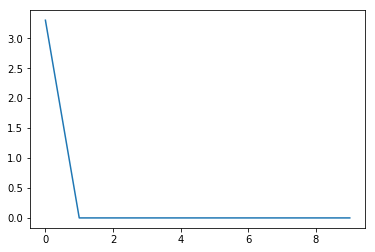

In [2]:
sig = zeros(10, dtype=float)
sig[0] = 3.3

figure()
plot(sig)

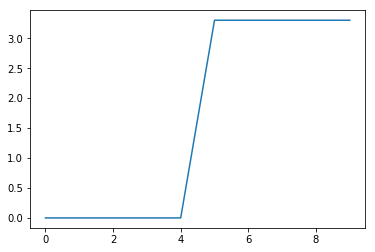

In [3]:
sig = arange(10, dtype=float)
amp = 3.3
mask = sig >= 5
sig[mask] = amp
sig[~mask] = 0

figure()
plot(sig)

In [3]:
# create and configure nidaq task
DEV = "Dev2"
CHAN_OUT = "ao0"

RATE = 1e3 * 10
DT = 1. / RATE
VMAX = 5.


outtask = nidaqmx.Task()

outtask.ao_channels.add_ao_voltage_chan(
    "/%s/%s" % (DEV, CHAN_OUT), 
    min_val=-VMAX, 
    max_val=VMAX)


outtask.timing.cfg_samp_clk_timing(
    rate=RATE, 
    samps_per_chan=len(sig), 
    sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS)

outtask.write(sig, timeout=10, auto_start=True)

10

Text(0.5,0,'Time (s)')

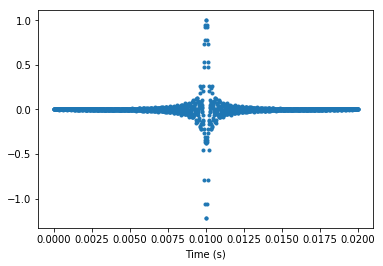

In [53]:
indata = empty(len(sig))
i = 0

intask.start()
outtask.start()

while i < len(sig):
    d = intask.read(1000)
    indata[i:i + len(d)] = d
    i += len(d)
    
outtask.stop()
intask.stop()


figure()

ts = arange(len(indata)) * DT
plot(ts, indata, '.')
xlabel("Time (s)")

# Analyze

In [54]:
def getPSD(tdata):
    fs = fft.rfftfreq(len(tdata), DT)

    Z = real(z * conj(z))
    Z /= float(len(tdata) * RATE)
    Z[1:] *= 2.

#     assert ((sum(Z)* 1./DT) - sum(tdata**2)) < 1e-6
    
    return Z, fs


Text(0,0.5,'PSD (V / $\\sqrt{\\mathsf{Hz}}$ )')

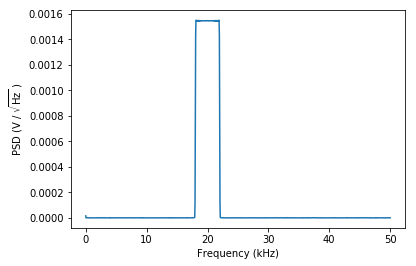

In [55]:

figure()

Z, fs = getPSD(indata)

plot(fs / 1e3, Z**0.5)

xlabel("Frequency (kHz)")
ylabel("PSD (V / $\sqrt{\mathsf{Hz}}$ )")

Text(0,0.5,'Normalized Response')

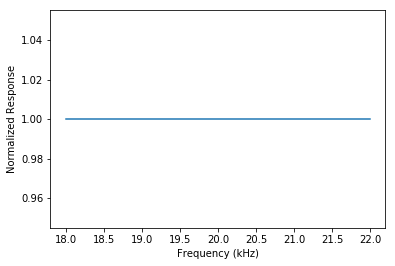

In [56]:
Zdrive, _ = getPSD(sig)

mask = Zdrive > mean(Zdrive)

figure()

plot(fs[mask] / 1e3, Z[mask] / Zdrive[mask])

xlabel("Frequency (kHz)")
ylabel("Normalized Response")
